In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time as time
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from xgboost import XGBClassifier


# from make_model import make_model
import sys
path = os.getcwd()
sys.path.append(path+'/scripts')
import param_grids
from make_model_3 import make_model_l, make_model_nl

In [2]:
data = path + '/dataset/bank/bank-additional/bank-additional-full.csv'
df_orig = pd.read_csv(data, sep=';')
print(f'size of the data --> {df_orig.shape}')
df_orig.head()

size of the data --> (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# create table listing column types etc
df = df_orig.copy()        # make a copy of the data before any transformations

df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'Duplicates dropped --> {df.duplicated().sum()}')
# drop duplicates, 12 rows
df = df.drop_duplicates()
df = df.drop('duration', axis=1)    # drop duration column
df_copy = df.copy()
df_info

Duplicates dropped --> 12


,column,dtype,NA_count,unique_count
0,age,int64,0,78
1,job,object,0,12
2,marital,object,0,4
3,education,object,0,8
4,default,object,0,3
5,housing,object,0,3
6,loan,object,0,3
7,contact,object,0,2
8,month,object,0,10
9,day_of_week,object,0,5


## Feature Selection

In [4]:
'''pipeline for preprocessing'''
# Drop response variable from the dataframe
y = df['y']
df = df.drop('y', axis=1)
X = df
# drop duration as it is not known before a call is performed
# df.drop('duration', axis=1)

# Create a pipeline for categorical features
cat_features = df.select_dtypes(include=['object']).columns
cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# df_cat= cat_pipeline.fit_transform(df[cat_features])

# Create a pipeline for numerical features
num_features = df.select_dtypes(include=['int64', 'float64']).columns
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Create a column transformer
preprocessor = ColumnTransformer([
        ('cat', cat_pipeline, cat_features),
        ('num', num_pipeline, num_features)
])

### Use K Best

Hard to use with encoded categorical data.

In [6]:
select = Pipeline([
        ('preprocessor', preprocessor),
        ('selector', SelectKBest(f_classif, k=19))
])

X_new = select.fit_transform(X, y)

best = select.fit(X, y)
best.get_feature_names_out()

print('features rejected:')
for i in range(len(best['selector'].get_support())): 
    if best['selector'].get_support()[i] == False:
        print(best.get_feature_names_out()[i])

features rejected:
cat__job_retired
cat__job_student
cat__default_no
cat__default_unknown
cat__contact_cellular
cat__month_mar
cat__month_may
cat__month_sep
cat__poutcome_nonexistent
cat__poutcome_success
num__duration
num__pdays
num__previous
num__emp.var.rate
num__cons.price.idx
num__euribor3m
num__nr.employed


IndexError: index 19 is out of bounds for axis 0 with size 19

Use with numerical to get an idea of feature importance.

In [8]:
# run select on just numerical features
X_num = X[num_features]
select_num = Pipeline([
        ('preprocessor', num_pipeline),
        ('selector', SelectKBest(f_classif, k=8))
])
best_num = select_num.fit(X_num, y)
print('features selected: ')
print(best_num.get_feature_names_out())
print('scores:{} '.format(best_num['selector'].scores_))
print('features rejected:')
print(X_num.columns[best_num['selector'].get_support() == False])

features selected: 
['duration' 'campaign' 'pdays' 'previous' 'emp.var.rate' 'cons.price.idx'
 'euribor3m' 'nr.employed']
scores:[  38.03776219 8092.86433112  182.12162486 4860.86431487 2304.02042926
 4021.29829691  777.46374246  124.0278517  4307.26454891 5924.52918989] 
features rejected:
Index(['age', 'cons.conf.idx'], dtype='object')


- Deal with 'unknowns' so data is less complex.
- Where unknowns are a very small percentage, we can impute them with the mode.
- Days of the week is one of the least "important" features so we can drop it.

In [7]:
'''write function to clean data based on EDA insights'''

def data_cleaner(df):
    df = df.drop_duplicates()   # drop duplicates
    df = df.drop(['day_of_week'], axis=1)   # drop day of week
    # df = df.drop(['duration'], axis=1)    # drop duration
    df = df.drop(['age'], axis=1)   # drop age
    df = df[df['education'] != 'illiterate']    # drop illiterate
    imp_mode = SimpleImputer(missing_values='unknown',strategy='most_frequent')   # impute unknowns
    df['marital'] = imp_mode.fit_transform(df[['marital']])  # impute unknowns
    df['housing'] = imp_mode.fit_transform(df[['housing']]) # impute unknowns
    df['loan'] = imp_mode.fit_transform(df[['loan']])       # impute unknowns
    df['job'] = imp_mode.fit_transform(df[['job']])     # impute unknowns
    df['education'] = imp_mode.fit_transform(df[['education']])    # impute unknowns
    return df

## New Models

- Train models on new dataset after feature selection.
- Check how much training time is reduced.
- Check if accuracy is improved.

### DT

With Cleaning

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 100}
Accuracy : 0.791664795113294
Training Time : 2 minutes
Test Score : 0.7953521762220194


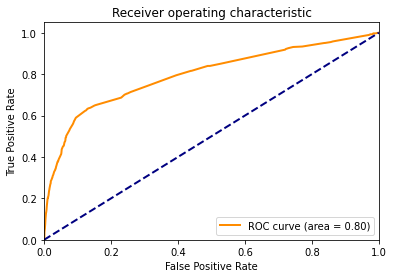

In [10]:
from make_model_2 import make_model_l, make_model_nl

random_state = 42
folds = 5
model_name = f'clean_new_dt_{folds}'
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

df = data_cleaner(df)
# y = df['y']
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

Without cleaning

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.933025588419673
Training Time : 2 minutes
Test Score : 0.9328570560336716


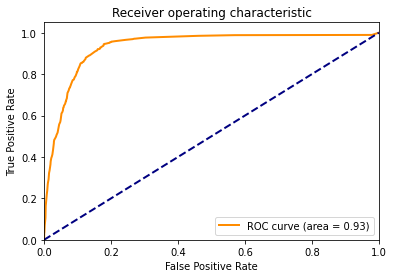

In [9]:
random_state = 42
folds = 5
model_name = f'new_dt_{folds}'
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

df = df_copy.copy()
# df = data_cleaner(df_orig)
# y = df['y']
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

- Accuracy increased by 0.1.
- Training time reduced by 0.6 minutes.
- Compare models trained on raw data and model trained on selected features.
- Raw data gives fae better performance, and there is not much of a difference in training times. 
- For text data, of this size, it is not too costly to train models without dropping too many features.

### LR

With cleaning

Tuned Hyperparameters : {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Accuracy : 0.7920872401823251
Training Time : 1 minutes
Test Score : 0.7925124626224505


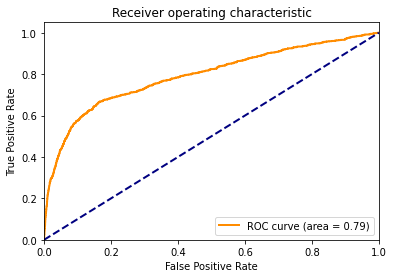

In [11]:
random_state = 42
folds = 5

model_name = f'clean_new_lr_{folds}'
model = LogisticRegression(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_lr

df = data_cleaner(df_copy)

clf_grid, time, test_score = make_model_l(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'
with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {time}\n")

without cleaning

Tuned Hyperparameters : {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Accuracy : 0.9345108763992783
Training Time : 1 minutes
Test Score : 0.9349157660649313


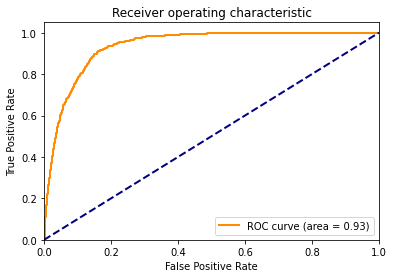

In [12]:
random_state = 42
folds = 5

model_name = f'new_lr_{folds}'
model = LogisticRegression(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_lr

df = df_copy.copy()

clf_grid, time, test_score = make_model_l(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'
with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {time}\n")

### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 30, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 300}
Accuracy : 0.944517823617265
Training Time : 13 minutes
Test Score : 0.9432616147052599


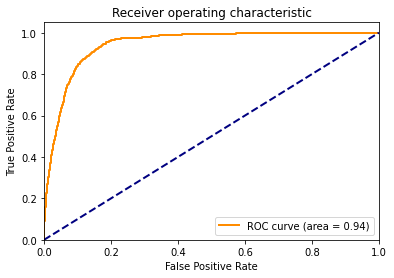

In [15]:
random_state = 42
folds = 5
model_name = f'new_rf_{folds}'
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_rf

df = df_copy.copy()
# df = data_cleaner(df_orig)
# y = df['y']
# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=random_state)

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### Stochastic Gradient Decsent Classifier

Tuned Hyperparameters : {'classifier__alpha': 0.001, 'classifier__loss': 'log', 'classifier__penalty': 'none'}
Accuracy : 0.93600211715949
Training Time : 2 minutes
Test Score : 0.9357975368704239


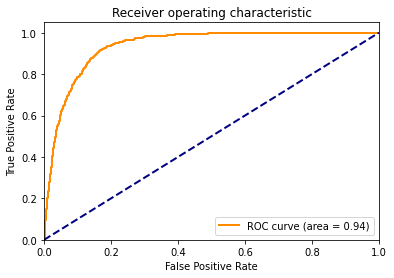

In [17]:
reload(param_grids)
random_state = 42
folds = 5

model_name = f'new_sgd_{folds}'
model = SGDClassifier(random_state=random_state)
parameters = param_grids.param_sgd

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)


pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### Naive Bayes

Tuned Hyperparameters : {'classifier__var_smoothing': 1.0}
Accuracy : 0.8660455384874867
Training Time : 0 minutes
Test Score : 0.866152947180889


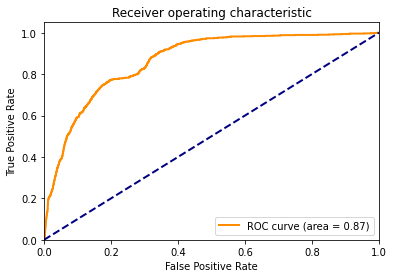

In [6]:
random_state = 42
folds = 10

model_name = f'new_nb_{folds}'
model = GaussianNB()
parameters = param_grids.param_nb

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)


pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### Compliment Naive Bayes

Tuned Hyperparameters : {'classifier__alpha': 0.001}
Accuracy : 0.7865555796609199
Training Time : 0 minutes
Test Score : 0.7783319579309946


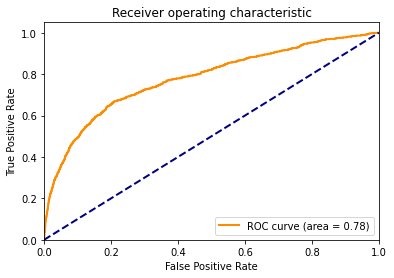

In [43]:
reload(param_grids)
import make_model_2
reload(make_model_2)
from make_model_2 import make_model_nl

random_state = 42
folds = 10

model_name = f'new_cnb_{folds}'
model = ComplementNB()
parameters = param_grids.param_cnb

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)


pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### AdaBoost

Tuned Hyperparameters : {'classifier__n_estimators': 300}
Accuracy : 0.9414924036289811
Training Time : 2 minutes
Test Score : 0.9432686442682334


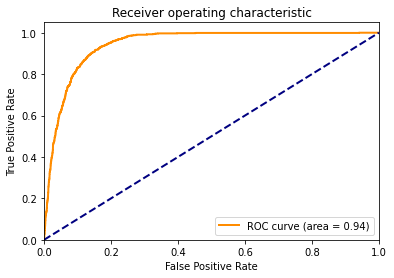

In [29]:
random_state = 42
folds = 5
model_name = f'new_ada_{folds}'
model = AdaBoostClassifier(random_state=random_state)
parameters = param_grids.param_ada

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### XgBoost

Tuned Hyperparameters : {'classifier__booster': 'gbtree', 'classifier__eval_metric': 'auc', 'classifier__gamma': 0.2, 'classifier__max_depth': 6}
Accuracy : 0.946780664722553
Training Time : 6 minutes
Test Score : 0.9450636724633712


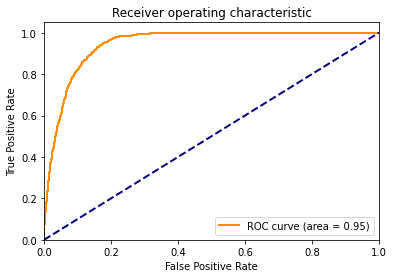

In [51]:
reload(param_grids)
import make_model_2
reload(make_model_2)
from make_model_2 import make_model_nl

random_state = 42
folds = 5

model_name = f'new_xgb_{folds}'
model = XGBClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_xgb  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

# Replace 'no' and 'yes' with 0 and 1, respectively
df['y'] = df['y'].map({'no': 0, 'yes': 1})

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


### Bagging Classifier

Tuned Hyperparameters : {'classifier__base_estimator': LogisticRegression(C=1, solver='liblinear'), 'classifier__n_estimators': 300}
Accuracy : 0.934499847604202
Training Time : 2 minutes
Test Score : 0.9347931880605803


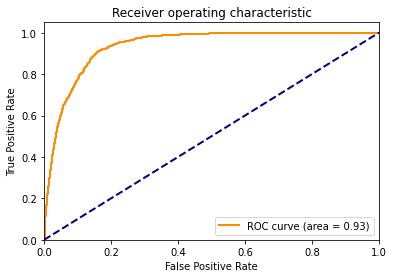

In [54]:
reload(param_grids)
import make_model_2
reload(make_model_2)
from make_model_2 import make_model_nl

random_state = 42
folds = 5

model_name = f'new_bag_{folds}'
model = BaggingClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_bag  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_copy.copy()

# Replace 'no' and 'yes' with 0 and 1, respectively
df['y'] = df['y'].map({'no': 0, 'yes': 1})

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


In [ ]:
clf = BaggingClassifier()
clf.get_params().keys()

# Try Using Re-Sampling

Since data is severly imbalanced, it would be prudent to employ some re-sampling techniques so that the model is able to learn. Let's use SMOTE+random Upsampling to check if accuracy imporves.

In [ ]:
from make_model_3 import make_model_nl      # make_model_3 has smote

### DT

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 100}
Accuracy : 0.9334445903414057
Training Time : 4 minutes
Test Score : 0.9357204313515578


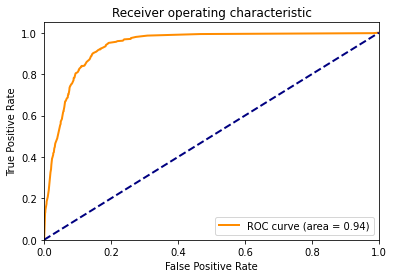

In [10]:
random_state = 42
folds = 5

over_size = 0.3
under_size = None
model_name = f'smote_dt_{over_size}_{under_size}'
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds, over_size=over_size, under_size=under_size)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

- Using SMOTE+random upsampling, accuracy increased marginally from 0.9328 to 0.9375.
- Training takes about twice as long as before.
- Results are better when the under sampling step is skipped. Pipeline sampler is only used to oversample the minority class.

### LR

Tuned Hyperparameters : {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Accuracy : 0.9362919575857461
Training Time : 1 minutes
Test Score : 0.9373320318878552


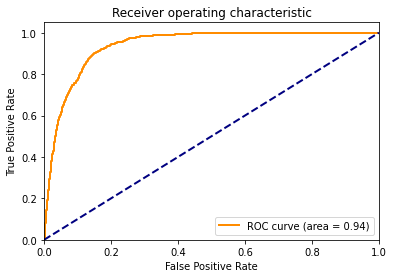

In [11]:
random_state = 42
folds = 5

over_size = "minority"
under_size = None
model_name = f'smote_lr_{over_size}_{under_size}'
model = LogisticRegression(random_state=random_state)
parameters = param_grids.param_lr

df = df_copy.copy()

clf_grid, time, test_score = make_model_l(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'
with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {time}\n")

- Using SMOTE has increased accuracy by 0.005, almost negligible. It caanot be claimed that the difference in accuracy is not due to random chance.
- Not much effect on training time.

### Adaboost

Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 100}
Accuracy : 0.9403108920426322
Training Time : 1 minutes
Test Score : 0.942173936284334


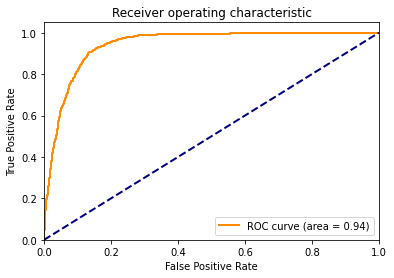

In [12]:
reload(param_grids)
random_state = 42
folds = 5
over_size = 0.2
under_size = 0.5
model_name = f'smote_ada_{over_size}_{under_size}'
model = AdaBoostClassifier(random_state=random_state)
parameters = param_grids.param_ada

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

- Using SMOTE actually reduces the accuracy for Adaboost.
- Training time is about the same.

### SGD

Tuned Hyperparameters : {'classifier__alpha': 0.001, 'classifier__learning_rate': 'optimal', 'classifier__loss': 'log', 'classifier__penalty': 'l1'}
Accuracy : 0.9362237774822922
Training Time : 8 minutes
Test Score : 0.9366290755905017


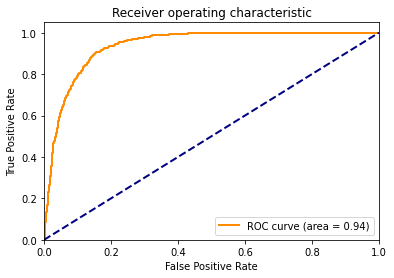

In [12]:
random_state = 42
folds = 5
over_size = "minority"
under_size = None
model_name = f'smote_sgd{over_size}_{under_size}'
model = SGDClassifier(random_state=random_state)
parameters = param_grids.param_sgd

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

- Training time increased by almost 3 minutes.
- No significant change in accuracy.

### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 300}
Accuracy : 0.8020056948267799
Training Time : 9 minutes
Test Score : 0.7894785748439768


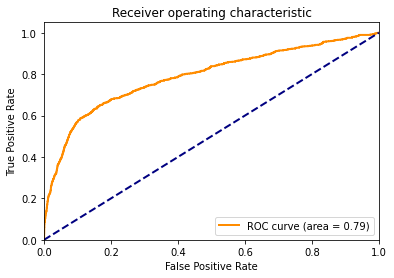

In [16]:
random_state = 42
folds = 5
over_size = "minority"
under_size = None
model_name = f'smote_rf{over_size}_{under_size}'
model = RandomForestClassifier(random_state=random_state)
parameters = param_grids.param_rf

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

- For random forest, accuracy drops significantly when using SMOTE. 

### Naive Bayes

In [ ]:
random_state = 42
folds = 10

model_name = f'smote_new_nb_{over_size}_{under_size}'
model = GaussianNB()
parameters = param_grids.param_nb

df = df_copy.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)


pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")